In [1]:
import cmdstanpy
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
import seaborn as sns
from matplotlib.animation import FuncAnimation

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_dir = Path.cwd().parent
full_df = pd.read_csv(project_dir / "data" / "transformed" / "dengue-sp-reporting-delay-proportion.csv", index_col=0)
delay_df = full_df.drop('y', axis=1)
print(full_df.iloc[-1])


delay_prop_0      1.0
delay_prop_1      0.0
delay_prop_2      0.0
delay_prop_3      0.0
delay_prop_4      0.0
delay_prop_5      0.0
delay_prop_6      0.0
delay_prop_7      0.0
delay_prop_8      0.0
delay_prop_9      0.0
delay_prop_10     0.0
delay_prop_11     0.0
delay_prop_12     0.0
delay_prop_13     0.0
delay_prop_14     0.0
delay_prop_15     0.0
delay_prop_16     0.0
delay_prop_17     0.0
delay_prop_18     0.0
delay_prop_19     0.0
delay_prop_20     0.0
delay_prop_21     0.0
delay_prop_22     0.0
delay_prop_23     0.0
delay_prop_24     0.0
delay_prop_25     0.0
delay_prop_26     0.0
delay_prop_27     0.0
delay_prop_28     0.0
delay_prop_29     0.0
delay_prop_30     0.0
delay_prop_31     0.0
delay_prop_32     0.0
delay_prop_33     0.0
delay_prop_34     0.0
delay_prop_35     0.0
delay_prop_36     0.0
delay_prop_37     0.0
delay_prop_38     0.0
delay_prop_39     0.0
y                19.0
Name: 2020-12-31, dtype: float64


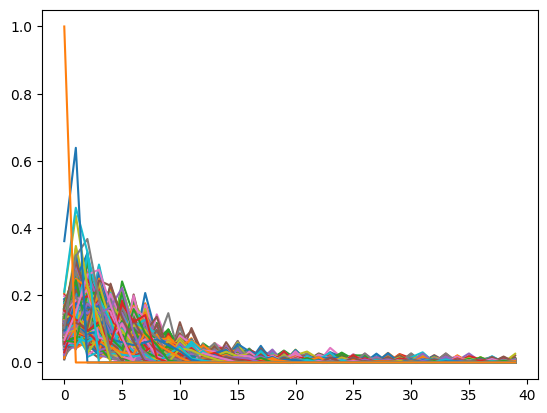

In [3]:
with open(project_dir / "config.yaml", 'r') as f:
    config = yaml.safe_load(f)

MAX_DELAY = config['model']['max_delay']



for t in range(len(delay_df)):
    row = delay_df.iloc[t]
    plt.plot(list(range(0, MAX_DELAY)), row)
plt.show()


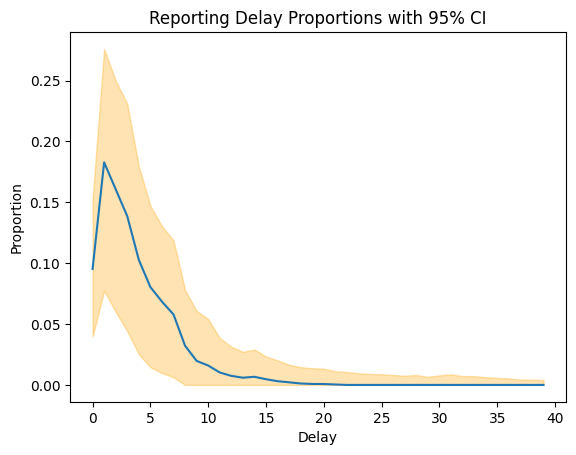

In [4]:
# Confidence intervals
median_ci = np.percentile(delay_df, 50, axis=0)
lower_ci = np.percentile(delay_df, 2.5, axis=0)
upper_ci = np.percentile(delay_df, 97.5, axis=0)

plt.plot(list(range(MAX_DELAY)), median_ci)
plt.fill_between(list(range(0, MAX_DELAY)), lower_ci, upper_ci, color='orange', alpha=0.3, label='95% CI (pred)')
plt.xlabel('Delay')
plt.ylabel('Proportion')
plt.title('Reporting Delay Proportions with 95% CI')
plt.show()


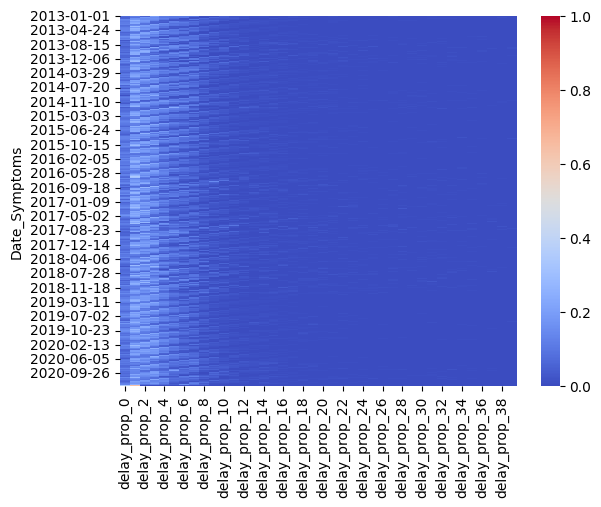

In [5]:
sns.heatmap(delay_df, annot=False, cmap='coolwarm', center=0.5)
plt.show()

In [6]:
cumsum_delay_df = delay_df.cumsum(axis=1)
cumsum_delay_df

,delay_prop_0,delay_prop_1,delay_prop_2,delay_prop_3,delay_prop_4,delay_prop_5,delay_prop_6,delay_prop_7,delay_prop_8,delay_prop_9,...,delay_prop_30,delay_prop_31,delay_prop_32,delay_prop_33,delay_prop_34,delay_prop_35,delay_prop_36,delay_prop_37,delay_prop_38,delay_prop_39
Date_Symptoms,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.026906,0.154709,0.284753,0.450673,0.500000,0.513453,0.652466,0.753363,0.822870,0.860987,...,0.988789,0.995516,0.995516,0.995516,0.997758,1.000000,1.000000,1.0,1.0,1.0
2013-01-02,0.041850,0.187225,0.310573,0.363436,0.398678,0.541850,0.645374,0.751101,0.812775,0.845815,...,0.977974,0.980176,0.982379,0.986784,0.991189,0.993392,0.997797,1.0,1.0,1.0
2013-01-03,0.063596,0.236842,0.298246,0.342105,0.502193,0.605263,0.719298,0.813596,0.864035,0.866228,...,0.986842,0.986842,0.993421,0.997807,0.997807,1.000000,1.000000,1.0,1.0,1.0
2013-01-04,0.071730,0.185654,0.234177,0.428270,0.540084,0.641350,0.746835,0.833333,0.839662,0.843882,...,0.991561,0.997890,0.997890,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
2013-01-05,0.063348,0.144796,0.298643,0.436652,0.570136,0.669683,0.773756,0.780543,0.785068,0.852941,...,0.993213,0.997738,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.102941,0.419118,0.786765,0.977941,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
2020-12-28,0.208054,0.644295,0.872483,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
2020-12-29,0.210526,0.671053,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0


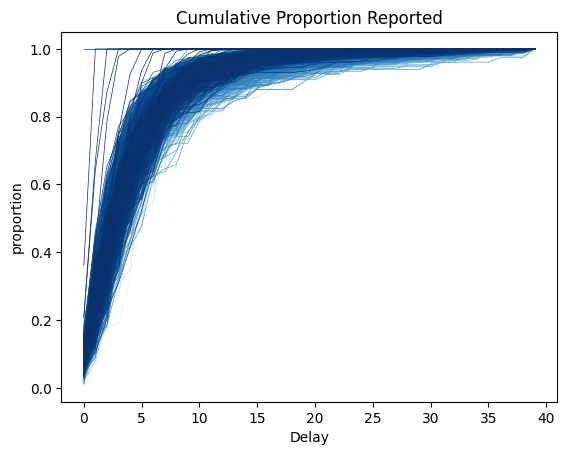

In [7]:
cmap = plt.cm.Blues
n_lines = len(cumsum_delay_df)

for t in range(n_lines):
    row = cumsum_delay_df.iloc[t]
    color = cmap(t / (n_lines - 1))
    plt.plot(list(range(0, MAX_DELAY)), row, color=color, lw=0.5)
plt.xlabel("Delay")
plt.ylabel("proportion")
plt.title("Cumulative Proportion Reported")
plt.show()

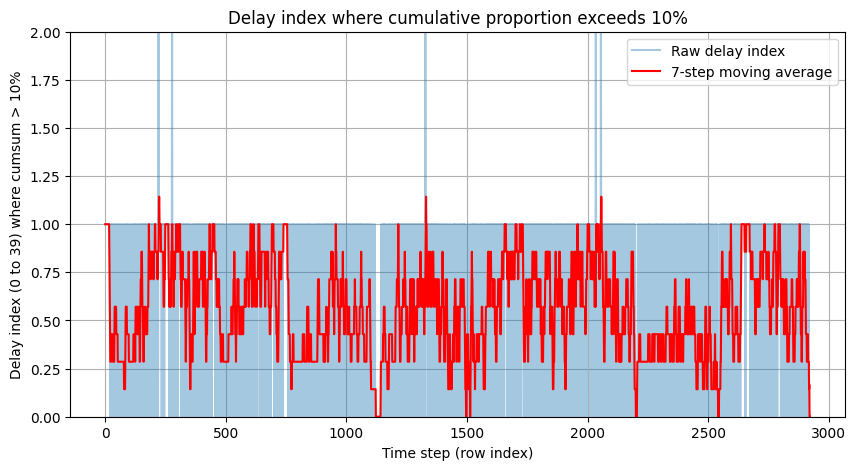

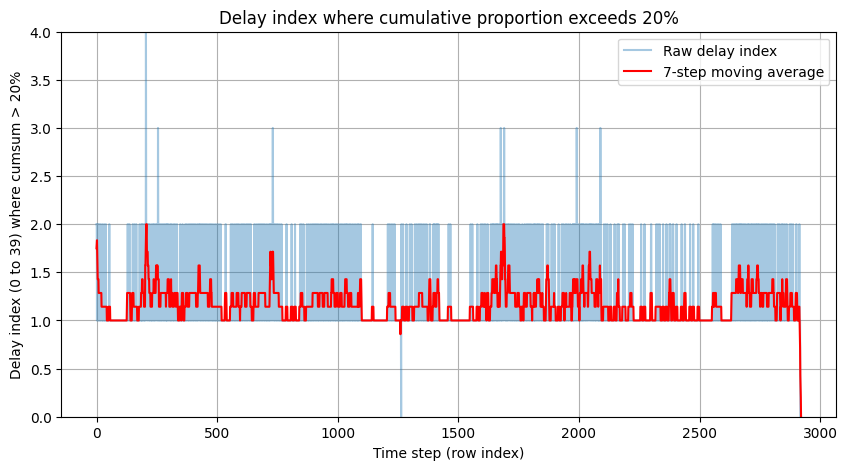

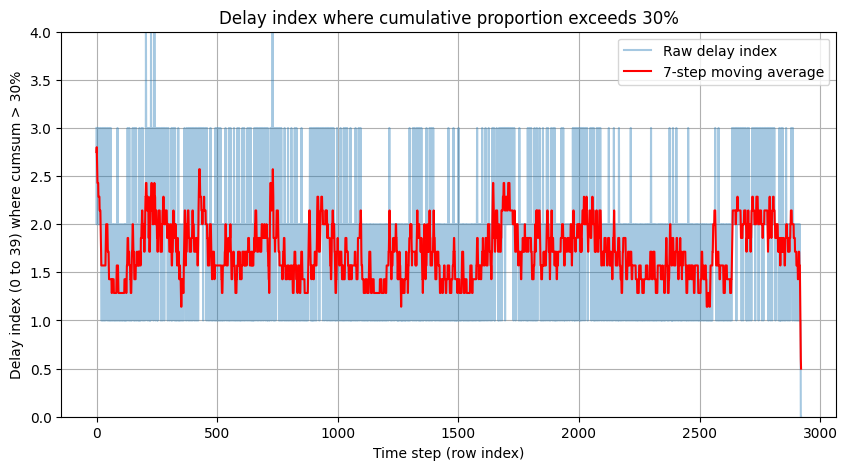

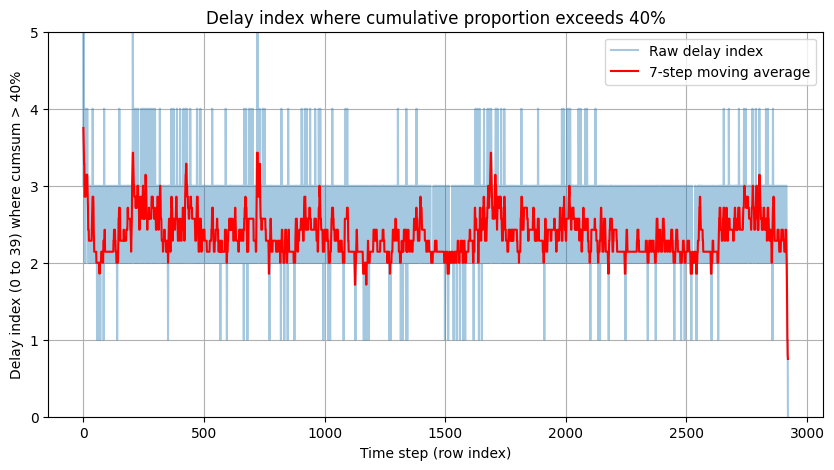

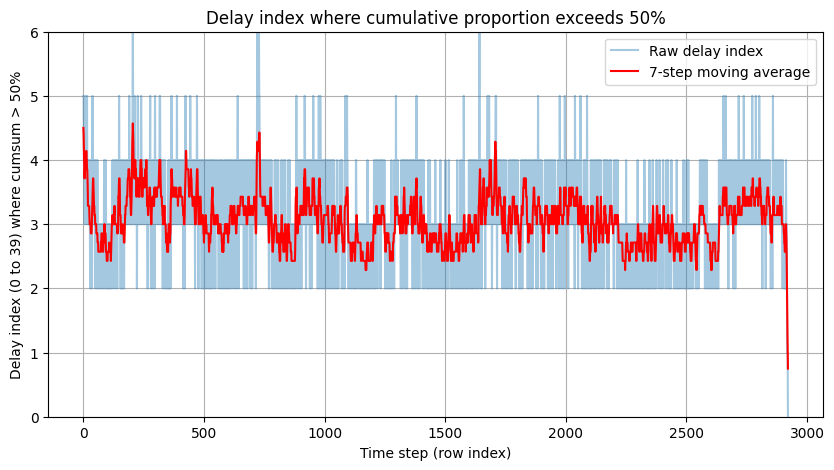

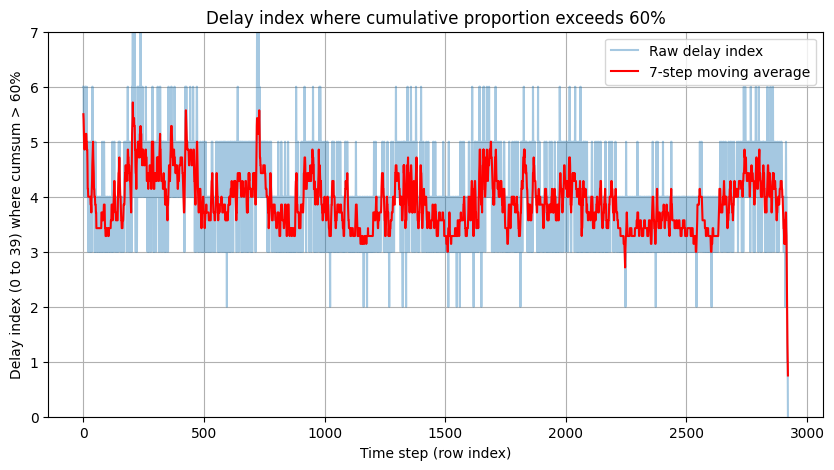

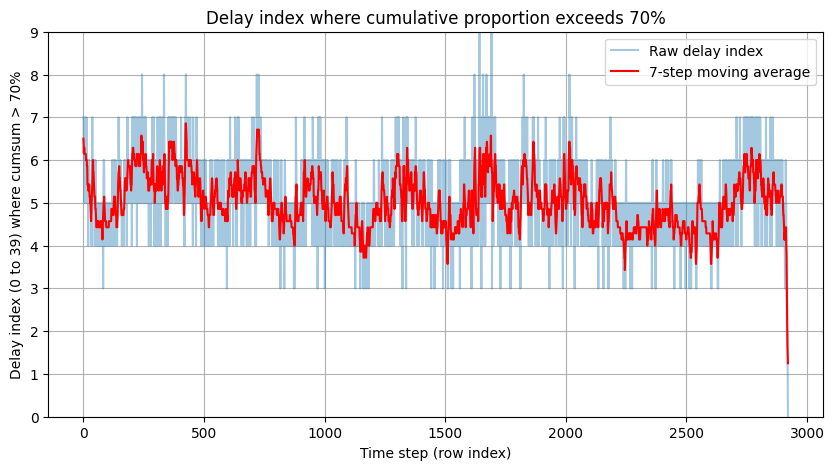

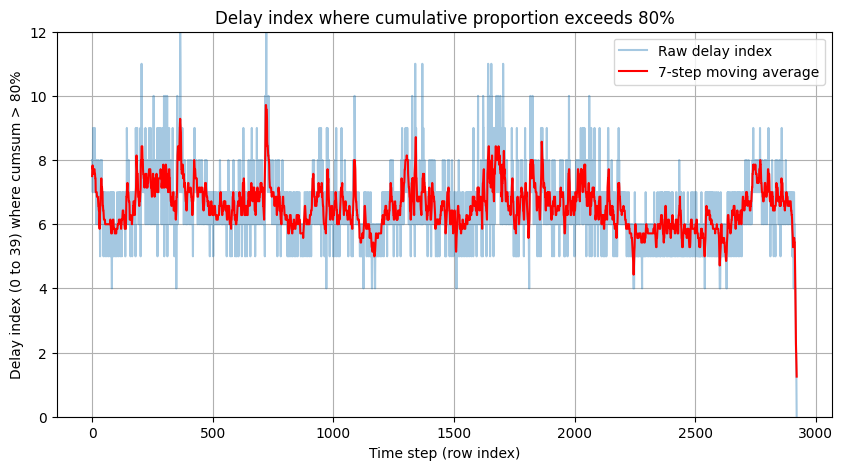

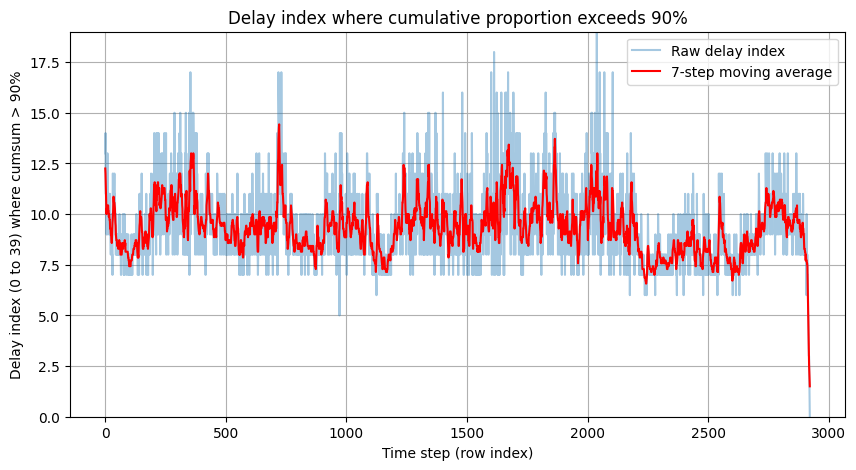

In [8]:
def plot_delay_cumulative_ts(cumsum_per, window=7):
    cumsum_prop = cumsum_per / 100
    num_delays = cumsum_delay_df.shape[1]

    # For each row, get the first column label where cumsum > cumsum_prop
    first_over_labels = cumsum_delay_df.apply(lambda row: (row > cumsum_prop).idxmax(), axis=1)

    # Convert column labels to their integer positions (0-based)
    col_pos_map = {col: i for i, col in enumerate(cumsum_delay_df.columns)}
    first_over_pos = first_over_labels.map(col_pos_map)

    # Compute moving average (rolling mean)
    first_over_ma = first_over_pos.rolling(window=window, min_periods=1, center=True).mean()

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(cumsum_delay_df)), first_over_pos.values, alpha=0.4, label='Raw delay index')
    plt.plot(range(len(cumsum_delay_df)), first_over_ma.values, color='red', label=f'{window}-step moving average')
    plt.xlabel('Time step (row index)')
    plt.ylabel(f'Delay index (0 to {num_delays - 1}) where cumsum > {cumsum_prop*100:.0f}%')
    plt.title(f'Delay index where cumulative proportion exceeds {cumsum_prop*100:.0f}%')
    plt.ylim(0, max(first_over_pos.values))
    plt.grid(True)
    plt.legend()
    plt.show()

for cumsum_prop in range(10, 100, 10):
    plot_delay_cumulative_ts(cumsum_prop)


Frame 0
Frame 1
Frame 2
Frame 3
Frame 4
Frame 5
Frame 6
Frame 7
Frame 8
Frame 9
Frame 10
Frame 11
Frame 12
Frame 13
Frame 14
Frame 15
Frame 16
Frame 17
Frame 18
Frame 19
Frame 20
Frame 21
Frame 22
Frame 23
Frame 24
Frame 25
Frame 26
Frame 27
Frame 28
Frame 29
Frame 30
Frame 31
Frame 32
Frame 33
Frame 34
Frame 35
Frame 36
Frame 37
Frame 38
Frame 39
Frame 40
Frame 41
Frame 42
Frame 43
Frame 44
Frame 45
Frame 46
Frame 47
Frame 48
Frame 49
Frame 50
Frame 51
Frame 52
Frame 53
Frame 54
Frame 55
Frame 56
Frame 57
Frame 58
Frame 59
Frame 60
Frame 61
Frame 62
Frame 63
Frame 64
Frame 65
Frame 66
Frame 67
Frame 68
Frame 69
Frame 70
Frame 71
Frame 72
Frame 73
Frame 74
Frame 75
Frame 76
Frame 77
Frame 78
Frame 79
Frame 80
Frame 81
Frame 82
Frame 83
Frame 84
Frame 85
Frame 86
Frame 87
Frame 88
Frame 89
Frame 90
Frame 91
Frame 92
Frame 93
Frame 94
Frame 95
Frame 96
Frame 97
Frame 98
Frame 99
Frame 100
Frame 101
Frame 102
Frame 103
Frame 104
Frame 105
Frame 106
Frame 107
Frame 108
Frame 109
Frame 110


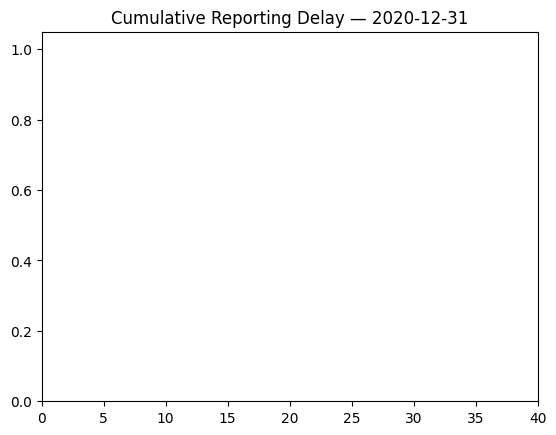

In [ ]:

# Create gif of cumulative proportion reported over time
x = np.arange(MAX_DELAY)
fig, ax = plt.subplots()
line, = ax.plot([], [], color='blue')
title = ax.set_title("")
ax.set_xlim(0, MAX_DELAY)
ax.set_ylim(0, 1.05)
ax.set_xlabel("Delay (days)")
ax.set_ylabel("Cumulative Proportion Reported")

def init():
    line.set_data([], [])
    return line,

def update(frame):
    print(f"Frame {frame}")
    y = cumsum_delay_df.iloc[frame].values
    line.set_data(x, y)
    
    # Get the corresponding date from the index
    date_str = pd.to_datetime(cumsum_delay_df.index[frame]).strftime('%Y-%m-%d')
    title.set_text(f"Cumulative Reporting Delay — {date_str}")
    
    return line,

ani = FuncAnimation(fig, update, frames=n_lines, init_func=init, blit=False, interval=500)

ani.save("test_line_animation.gif", fps=5, dpi=150)
